In [ ]:
! pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 7.6MB/s 


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential, Input
import tensorflow_model_optimization as tfmot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow import concat
from tensorflow import lite

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/Master_1/ComputerVision/chess/"
import os
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/Master_1/ComputerVision/chess/dataset.zip",'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Mounted at /content/drive
 chessBoardProcessing
'Chess piece detection Training.ipynb'
'Chess piece to FEN.ipynb'
 dataset.zip
 niebun.jpg
 quick_test2.jpg
 quick_test.jpg
 riejina.jpg
 save_at_epoch_3_fine_tunned.h5
 save_at_epoch_5_fine_tunned.h5
 save_at_epoch_5_fine_tunned_prunned.h5
 save_at_epoch_5_fine_tunned_quantized_and_pruned.tflite
 save_at_epoch_5_fine_tunned_quantized_and_pruned.tflite.zip
 save_at_epoch_5.h5
 tura.jpg
 wide_horse.jpg


In [ ]:
!ls "/tmp/chessvision-main/data"

bb  bk	bn  bp	bq  br	em  wb	wk  wn	wp  wq	wr


In [ ]:
def get_data_augmentation():
  return Sequential(
      [
        RandomFlip("horizontal"),
        RandomFlip("vertical"),
        RandomRotation(0.4),
        RandomZoom(0.2)
      ]
    )


def get_model():
  # training
  data_augmentation = get_data_augmentation()
  classifier_activation = 'softmax'
  input_shape = (150, 150, 3)
  pooling = 'avg'
  classes = 13

  # use data augmentation on training
  inputs = Input(shape=input_shape)
  x = data_augmentation(inputs)
  x = Rescaling(1./255)(x)

  # use InceptionResNetV2
  base_model = InceptionResNetV2(include_top=False, input_tensor=x, weights='imagenet', pooling=pooling, classes=classes, classifier_activation=classifier_activation)

  # put our own top lvl
  x = base_model.output
  x = Dense(512, activation='relu')(x)
  predictions = Dense(classes, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  # freeze all except the top layer
  for layer in base_model.layers:
      layer.trainable = False

  model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

  return model


def prepare_for_fine_tunning(model, no_layers_to_freeze = 249):
  # fine tune by keeping freezed only the first 249 no_layers_to_freeze
  for layer in model.layers[:no_layers_to_freeze]:
    layer.trainable = False
  for layer in model.layers[no_layers_to_freeze:]:
    layer.trainable = True

  model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
train_dataset = image_dataset_from_directory('/tmp/chessvision-main/data', label_mode='categorical', image_size=(150, 150), validation_split=0.2, subset='training', seed=24)
validation_dataset = image_dataset_from_directory('/tmp/chessvision-main/data', label_mode='categorical', image_size=(150, 150), validation_split=0.2, subset='validation', seed=24)
train_dataset = train_dataset.prefetch(buffer_size=32)
validation_dataset = validation_dataset.prefetch(buffer_size=32)

Found 70214 files belonging to 13 classes.
Using 56172 files for training.
Found 70214 files belonging to 13 classes.
Using 14042 files for validation.


In [ ]:
callbacks = [
    ModelCheckpoint("save_at_epoch_{epoch}.h5"),
]
# get InceptionResNetV2
model = get_model()
# train
epochs = 5
model.fit(train_dataset, epochs=epochs, callbacks=callbacks, validation_data=validation_dataset)

Epoch 1/5
1756/1756 [==============================] - 232s 108ms/step - loss: 0.7575 - accuracy: 0.7905 - val_loss: 0.3444 - val_accuracy: 0.8941
Epoch 2/5
1756/1756 [==============================] - 187s 106ms/step - loss: 0.3449 - accuracy: 0.8896 - val_loss: 0.2922 - val_accuracy: 0.9101
Epoch 3/5
1756/1756 [==============================] - 188s 107ms/step - loss: 0.2970 - accuracy: 0.9032 - val_loss: 0.2349 - val_accuracy: 0.9291
Epoch 4/5
1756/1756 [==============================] - 188s 107ms/step - loss: 0.2692 - accuracy: 0.9135 - val_loss: 0.2322 - val_accuracy: 0.9286
Epoch 5/5
1756/1756 [==============================] - 187s 107ms/step - loss: 0.2401 - accuracy: 0.9254 - val_loss: 0.2037 - val_accuracy: 0.9376


In [ ]:
callbacks = [
    ModelCheckpoint("save_at_epoch_{epoch}_fine_tunned.h5"),
]
# prepare for fine tunning
model = prepare_for_fine_tunning(model)
# re-train to fine tune
epochs = 5
model.fit(train_dataset, epochs=epochs, callbacks=callbacks, validation_data=validation_dataset)

Epoch 1/5
1756/1756 [==============================] - 427s 235ms/step - loss: 0.2277 - accuracy: 0.9306 - val_loss: 0.0585 - val_accuracy: 0.9875
Epoch 2/5
1756/1756 [==============================] - 408s 232ms/step - loss: 0.0630 - accuracy: 0.9841 - val_loss: 0.0448 - val_accuracy: 0.9901
Epoch 3/5
1756/1756 [==============================] - 408s 232ms/step - loss: 0.0478 - accuracy: 0.9878 - val_loss: 0.0389 - val_accuracy: 0.9911
Epoch 4/5
1756/1756 [==============================] - 408s 232ms/step - loss: 0.0387 - accuracy: 0.9904 - val_loss: 0.0562 - val_accuracy: 0.9852
Epoch 5/5
1756/1756 [==============================] - 408s 232ms/step - loss: 0.0367 - accuracy: 0.9898 - val_loss: 0.0396 - val_accuracy: 0.9904


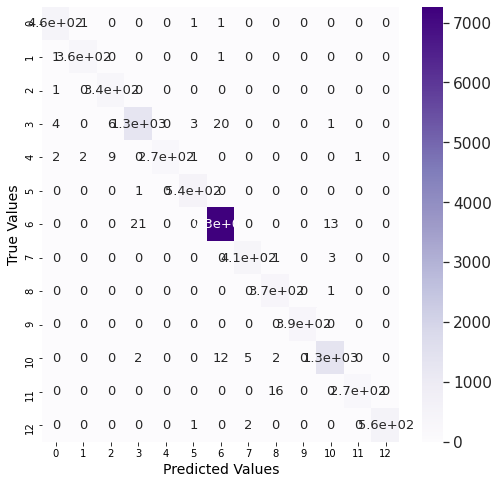

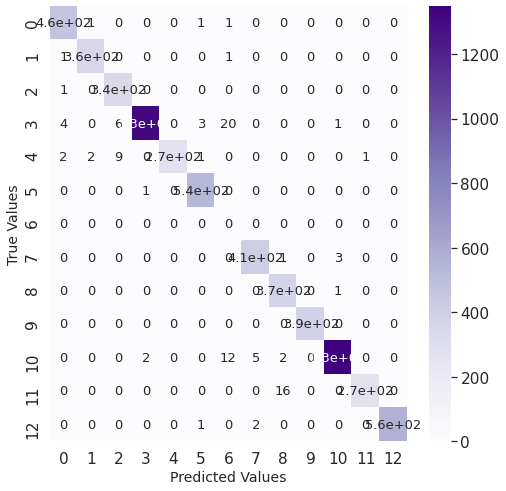

In [ ]:
def get_confusion_matrix(labels, predictions, skip_em=True):
  if skip_em is True:
    labels_and_predictions = zip(labels, predictions)
    labels_and_predictions = filter(lambda x: x[0] !=6, labels_and_predictions)
    labels, predictions = zip(*labels_and_predictions)

  cm = confusion_matrix(labels, predictions)
  fig = plt.figure(figsize = (8,8))
  ax1 = fig.add_subplot(1,1,1)
  sns.set(font_scale=1.4)
  sns.heatmap(cm, annot=True, annot_kws={"size": 13},
      cbar = True, cmap='Purples');
  ax1.set_ylabel('True Values', fontsize=14)
  ax1.set_xlabel('Predicted Values', fontsize=14)
  plt.show()

predictions = np.array([])
labels =  np.array([])
for x, y in validation_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
get_confusion_matrix(labels, predictions, skip_em=False)
get_confusion_matrix(labels, predictions)

In [ ]:
def get_gzipped_model_size(file):
  # saves as gzip and returns the size of the gzipped model
  import zipfile
  import os

  zipped_file = file + '.zip'
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
# pruning and saving as tflite

# uncomment if already trained
keras_model_file = '/content/drive/My Drive/Master_1/ComputerVision/chess/save_at_epoch_5_fine_tunned.h5'
model = load_model(keras_model_file)

model_for_export = tfmot.sparsity.keras.strip_pruning(model)
pruned_h5_file = '/content/drive/My Drive/Master_1/ComputerVision/chess/save_at_epoch_5_fine_tunned_prunned.h5'
save_model(model_for_export, pruned_h5_file)

In [ ]:
converter = lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

quantized_and_pruned_tflite_file = '/content/drive/My Drive/Master_1/ComputerVision/chess/save_at_epoch_5_fine_tunned_quantized_and_pruned.tflite'

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

In [ ]:
# Load the TFLite model and allocate tensors. View details
interpreter = lite.Interpreter(model_path="/content/drive/My Drive/Master_1/ComputerVision/chess/save_at_epoch_5_fine_tunned_quantized_and_pruned.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and transform image
image_a = plt.imread('/content/drive/My Drive/Master_1/ComputerVision/chess/tura.jpg')
input_data = np.expand_dims(image_a, axis=0).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(np.argmax(output_data, axis=-1))

[12]
